# Starting info

- Our brand is Grotal

In [94]:
import importlib

import pandas as pd
import seaborn as sns
import daft as d
import matplotlib.pyplot as plt
import utils as ut

In [108]:
importlib.reload(ut)

<module 'utils' from '/Users/zakhar/Desktop/code/xttr-test-brands/utils.py'>

# Reading the file

In [2]:
df = pd.read_csv('test_brand_data.csv')
df2 = d.from_pandas(df)

# Datatype conversion

In [8]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
# Have a look at the data
print(df.head())

        date    brand  region  total_sales  total_items_count  \
0 2027-02-06  Словора  Москва   2679000.97              23299   
1 2027-01-02   Зефора  Москва   2567184.96              19403   
2 2027-02-27  Словора  Москва   2869078.09              22382   
3 2027-01-02   Каморн  Москва   2899584.85              26983   
4 2027-01-02  Словора  Москва   4758714.46              51520   

   total_receipts_count  total_stores_count  
0                 20085                 927  
1                 16886                 855  
2                 19289                 932  
3                 23316                 932  
4                 42814                 927  


# Let's make a dataframe with only the data from last 6 months

It will help us analyse the latest trends

In [96]:
df_hy = ut.slice_last_mo(df, 6)

/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/2403300315.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  top_brand_plot.set_xticklabels(top_brand_plot.get_xticklabels(), rotation=45)


[Text(21153.0, 0, '2027-12'),
 Text(21184.0, 0, '2028-01'),
 Text(21215.0, 0, '2028-02'),
 Text(21244.0, 0, '2028-03'),
 Text(21275.0, 0, '2028-04'),
 Text(21305.0, 0, '2028-05'),
 Text(21336.0, 0, '2028-06')]

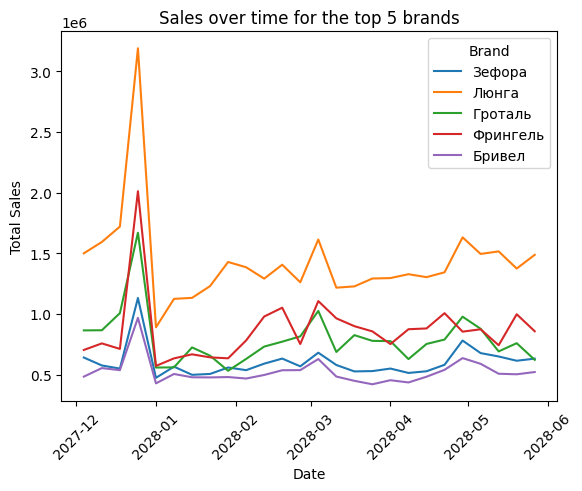

In [ ]:
# Let's take top 5 brands by cumulative sales
top_5 = ut.get_top_brands(df_hy, 5)

# Draw line chart of sales over time for the top 5 brands
top_5 = top_5.index
df_top_brands = df_hy[df_hy['brand'].isin(top_5)]
# Chart without confidence intervals
top_brand_plot = sns.lineplot(data=df_top_brands, x='date', y='total_sales', hue='brand', errorbar=None)
# Format the x-axis
# top_brand_plot.set_xlim(three_months_ago, last_date)
# Format the labels
top_brand_plot.set(xlabel='Date', ylabel='Total Sales', title='Sales over time for the top 5 brands')
# Add a legend with a title
top_brand_plot.legend(title='Brand')
# Format the numbers as currency
# top_brand_plot.yaxis.set_major_formatter('${x:,.0f}')
# Rotate the x-axis labels
top_brand_plot.set_xticklabels(top_brand_plot.get_xticklabels(), rotation=45)

We've ironed out the main rivals as:
- Зефора
- Люнга
- Гроталь
- Бривел
- Фрингель

P.S. We had a sharp drop in sales over the last several weeks, and our competitors (Fringel and Lunga) had sales rise.

Let's now dissect the sales for Grotal and Fringel and Lunga:
- by region
- by price

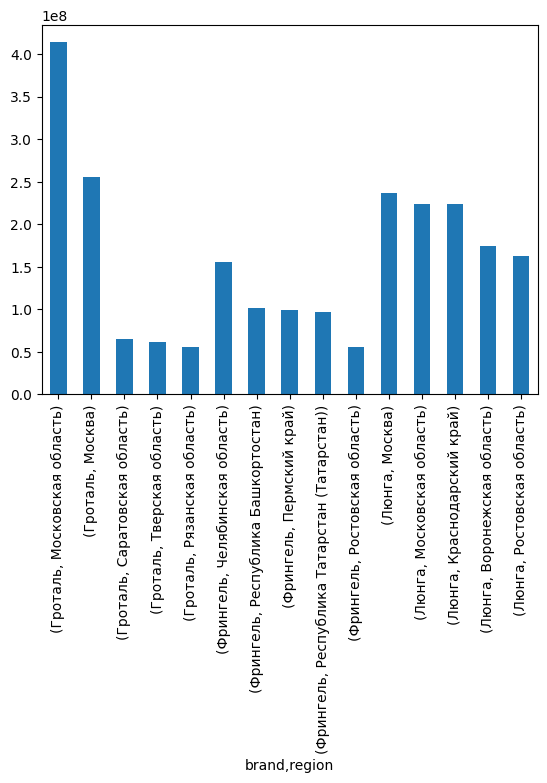

In [ ]:
# Getting top 10 regions for the brand "Гроталь"
grotal = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Гроталь")
fringel = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Фрингель")
lunga = ut.get_top_regions(df_hy, 5, 'brand', 'region', 'total_sales', "Люнга")

grotal_regions = grotal.index
fringel_grotal = df_hy[df_hy['brand'].isin(grotal_regions)].groupby(['brand', 'region'])['total_sales'].sum().reset_index()
lunga_grotal = df_hy[df_hy['brand'].isin(grotal_regions)].groupby(['brand', 'region'])['total_sales'].sum().reset_index()
# Concatenate the dataframes
top_regions = pd.concat([grotal, fringel, lunga]).plot(kind='', x='region', y='total_sales')

[Text(0.5, 23.42847222222222, 'Region'),
 Text(50.722222222222214, 0.5, 'Brand'),
 Text(0.5, 1.0, 'Sales by brand and region in the last month')]

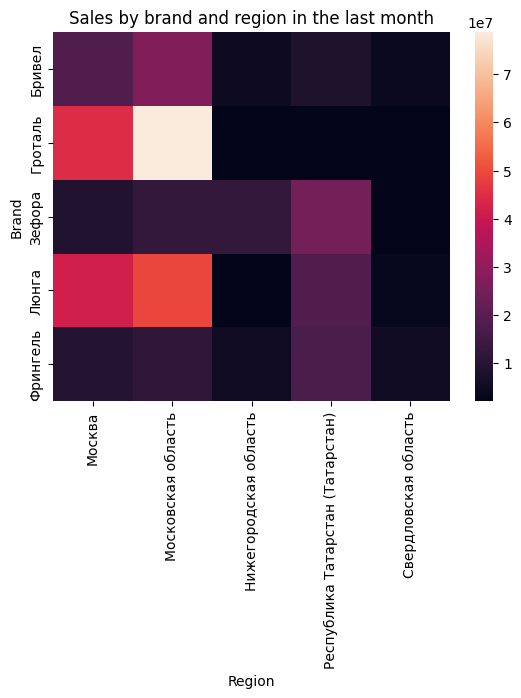

In [97]:
# Top regions by sales
top_regions = df_hy.groupby('region')['total_sales'].sum().sort_values(ascending=False).head(5)

# Take the last month of data
last_month = ut.slice_last_mo(df, 1)

# Get the top 5 brands by sales in the last month
top_brands_last_month = ut.get_top_brands(last_month, 5)

# Draw a heatmap of sales by brand and region, for the top 5 brands and top 5 regions in the last month
top_brands_last_month = top_brands_last_month.index
top_regions = top_regions.index

# Filter the data
df_heatmap = last_month[(last_month['brand'].isin(top_brands_last_month)) & (last_month['region'].isin(top_regions))]

# Pivot the data so that brands are on the y-axis and regions are on the x-axis
df_heatmap = df_heatmap.pivot_table(index='brand', columns='region', values='total_sales', aggfunc='sum')

# Draw the heatmap
heatmap = sns.heatmap(df_heatmap, fmt=',.0f')

# Format the labels
heatmap.set(xlabel='Region', ylabel='Brand', title='Sales by brand and region in the last month')

In [64]:
# в каких регионах у меня выросли или упали продажи относительно конкурентов?

# Get the last 2 months of data
two_mos = slice_last_mo(df, 2)

# Calculate monthly sales for each of the top brands for each of the 2 last months
monthly_sales = two_mos.groupby(['brand', pd.Grouper(key='date', freq='ME')])['total_sales'].sum().unstack()

In [83]:
monthly_sales['change'] = monthly_sales.pct_change(axis=1).iloc[:, 1] # Copilot suggested to use pct_change and iloc
# Format the numbers as percentages
# monthly_sales['change'] = monthly_sales['change'].map('{:.2%}'.format)
monthly_sales.head()

date,2028-04-30 00:00:00,2028-05-31 00:00:00,change
brand,,,
Брефора,1.208706e+07,1.064583e+07,-0.119237
Бривел,1.763778e+08,1.462637e+08,-0.170737
Венжера,7.366549e+06,5.945125e+06,-0.192957
Вунтель,4.734626e+07,3.734823e+07,-0.211168
Гирба,3.338615e+07,2.747130e+07,-0.177165


/var/folders/6s/xfrpp0xd2wlfbjl7gn_y82qw0000gn/T/ipykernel_90223/73080851.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis')


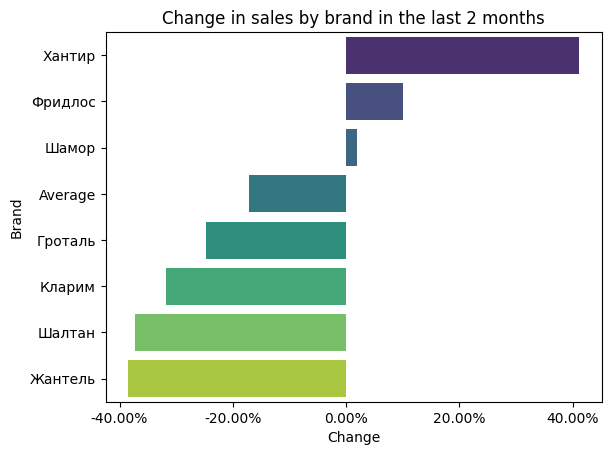

In [ ]:
# Plot top 5, average, Гроталь and bottom 5 by change column as a horizontal bar chart
# Calculate the average change
average_change = monthly_sales['change'].mean()
# Add average change to the data
average_change = pd.Series(average_change, index=['Average'])
# Calculate the change for the top 5 brands
top_5 = monthly_sales['change'].nlargest(3).sort_values(ascending=False)
# Calculate the change for the bottom 5 brands
bottom_3 = monthly_sales['change'].nsmallest(3).sort_values(ascending=False)
# Grotal 
grotal_change = monthly_sales.loc['Гроталь', 'change']
grotal_change = pd.Series(grotal_change, index=['Гроталь'])
# Concatenate the data
change_data = pd.concat([top_5, average_change, grotal_change, bottom_3])
# Plot the data
change_plot = sns.barplot(x=change_data, y=change_data.index, palette='viridis')
# Format the labels
change_plot.set(xlabel='Change', ylabel='Brand', title='Change in sales by brand in the last 2 months')
# Format the numbers as percentages
change_plot.xaxis.set_major_formatter('{:.2%}'.format)
# Less ticks
change_plot.xaxis.set_major_locator(plt.MaxNLocator(5))

# Potential metrics

- sales by brand
- average items per receipt by brand
- average receipt value by brand
- average receipt size by region
- average receipt value by region
- stores by brand over time

In [13]:
# Let's define some other metrics

# Items per receipt
df['items_per_receipt'] = df['total_items_count'] / df['total_receipts_count']
# Avg receipt value
df['avg_receipt_value'] = df['total_sales'] / df['total_receipts_count']
# Avg sales per store
df['sales_per_store'] = df['total_sales'] / df['total_stores_count']
# Average item price
df['avg_item_price'] = df['total_sales'] / df['total_items_count']